In [15]:
import tensorflow as tf

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split

import os
import random

#  Definition of the Segmentation Model

## Utilities
### Taken from https://github.com/camara94/computer_vision_lab/blob/main/C3_W3_Lab_2_OxfordPets_UNet.ipynb and adapted to binary classification

In [16]:
# Encoder Utilities

def conv2d_block(input_tensor, n_filters, kernel_size = 3):
  '''
  Adds 2 convolutional layers with the parameters passed to it

  Args:
    input_tensor (tensor) -- the input tensor
    n_filters (int) -- number of filters
    kernel_size (int) -- kernel size for the convolution

  Returns:
    tensor of output features
  '''
  # first layer
  x = input_tensor
  for i in range(2):
    x = tf.keras.layers.Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
            kernel_initializer = 'he_normal', padding = 'same')(x)
    x = tf.keras.layers.Activation('relu')(x)
  
  return x


def encoder_block(inputs, n_filters=64, pool_size=(2,2), dropout=0.3):
  '''
  Adds two convolutional blocks and then perform down sampling on output of convolutions.

  Args:
    input_tensor (tensor) -- the input tensor
    n_filters (int) -- number of filters
    kernel_size (int) -- kernel size for the convolution

  Returns:
    f - the output features of the convolution block 
    p - the maxpooled features with dropout
  '''

  f = conv2d_block(inputs, n_filters=n_filters)
  p = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(f)
  p = tf.keras.layers.Dropout(0.3)(p)

  return f, p


def encoder(inputs):
  '''
  This function defines the encoder or downsampling path.

  Args:
    inputs (tensor) -- batch of input images

  Returns:
    p4 - the output maxpooled features of the last encoder block
    (f1, f2, f3, f4) - the output features of all the encoder blocks
  '''
  f1, p1 = encoder_block(inputs, n_filters=64, pool_size=(2,2), dropout=0.3)
  f2, p2 = encoder_block(p1, n_filters=128, pool_size=(2,2), dropout=0.3)
  f3, p3 = encoder_block(p2, n_filters=256, pool_size=(2,2), dropout=0.3)
  f4, p4 = encoder_block(p3, n_filters=512, pool_size=(2,2), dropout=0.3)

  return p4, (f1, f2, f3, f4)

In [17]:
def bottleneck(inputs):
  '''
  This function defines the bottleneck convolutions to extract more features before the upsampling layers.
  '''
  
  bottle_neck = conv2d_block(inputs, n_filters=1024)

  return bottle_neck

In [18]:
# Decoder Utilities

def decoder_block(inputs, conv_output, n_filters=64, kernel_size=3, strides=3, dropout=0.3):
  '''
  defines the one decoder block of the UNet

  Args:
    inputs (tensor) -- batch of input features
    conv_output (tensor) -- features from an encoder block
    n_filters (int) -- number of filters
    kernel_size (int) -- kernel size
    strides (int) -- strides for the deconvolution/upsampling
    padding (string) -- "same" or "valid", tells if shape will be preserved by zero padding

  Returns:
    c (tensor) -- output features of the decoder block
  '''
  u = tf.keras.layers.Conv2DTranspose(n_filters, kernel_size, strides = strides, padding = 'same')(inputs)
  c = tf.keras.layers.concatenate([u, conv_output])
  c = tf.keras.layers.Dropout(dropout)(c)
  c = conv2d_block(c, n_filters, kernel_size=3)

  return c


def decoder(inputs, convs, output_channels):
  '''
  Defines the decoder of the UNet chaining together 4 decoder blocks. 
  
  Args:
    inputs (tensor) -- batch of input features
    convs (tuple) -- features from the encoder blocks
    output_channels (int) -- number of classes in the label map

  Returns:
    outputs (tensor) -- the pixel wise label map of the image
  '''
  
  f1, f2, f3, f4 = convs

  c6 = decoder_block(inputs, f4, n_filters=512, kernel_size=(3,3), strides=(2,2), dropout=0.3)
  c7 = decoder_block(c6, f3, n_filters=256, kernel_size=(3,3), strides=(2,2), dropout=0.3)
  c8 = decoder_block(c7, f2, n_filters=128, kernel_size=(3,3), strides=(2,2), dropout=0.3)
  c9 = decoder_block(c8, f1, n_filters=64, kernel_size=(3,3), strides=(2,2), dropout=0.3)

  outputs = tf.keras.layers.Conv2D(output_channels, (1, 1), activation='softmax' if output_channels > 1 else 'sigmoid')(c9)

  return outputs

## Model

In [19]:
OUTPUT_CHANNELS = 1

def unet(shape=(128, 128,3,)):
  '''
  Defines the UNet by connecting the encoder, bottleneck and decoder.
  '''

  # specify the input shape
  inputs = tf.keras.layers.Input(shape=shape)

  # feed the inputs to the encoder
  encoder_output, convs = encoder(inputs)

  # feed the encoder output to the bottleneck
  bottle_neck = bottleneck(encoder_output)

  # feed the bottleneck and encoder block outputs to the decoder
  # specify the number of classes via the `output_channels` argument
  outputs = decoder(bottle_neck, convs, output_channels=OUTPUT_CHANNELS)
  
  # create the model
  model = tf.keras.Model(inputs=inputs, outputs=outputs)

  return model

# instantiate the model
model = unet((256, 256,3,))

# see the resulting model architecture
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d_19 (Conv2D)          (None, 256, 256, 64)         1792      ['input_2[0][0]']             
                                                                                                  
 activation_18 (Activation)  (None, 256, 256, 64)         0         ['conv2d_19[0][0]']           
                                                                                                  
 conv2d_20 (Conv2D)          (None, 256, 256, 64)         36928     ['activation_18[0][0]']       
                                                                                            

In [20]:
# from tensorflow.keras.utils import plot_model

# # Plot the model architecture
# plot_model(model, to_file='unet_model.png', show_shapes=True, show_layer_names=True)


# Dataset preparation

In [21]:
from tensorflow.keras.utils import Sequence


class DataGenerator(Sequence):
    def __init__(self, image_dir, mask_dir, batch_size=32, image_size=(256, 256), shuffle=True):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.image_filenames = os.listdir(self.image_dir)
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.image_filenames) / self.batch_size))

    def __getitem__(self, index):
        batch_filenames = self.image_filenames[index * self.batch_size:(index + 1) * self.batch_size]
        images, masks = self.__data_generation(batch_filenames)
        return images, masks

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.image_filenames)

    def __data_generation(self, batch_filenames):
        images = np.empty((self.batch_size, *self.image_size, 3), dtype=np.float32)
        masks = np.empty((self.batch_size, *self.image_size, 1), dtype=np.float32)
        for i, filename in enumerate(batch_filenames):
            img_path = os.path.join(self.image_dir, filename)
            img = Image.open(img_path).resize(self.image_size)
            img = np.array(img) / 255.0
            images[i] = img

            mask_filename = 'mask_' + '_'.join(filename.split('_')[1:])
            if ' ' in mask_filename:
                fn_1 = mask_filename.split(' ')[0]
                fn_2 = mask_filename.split('.')[-1]
                mask_filename = fn_1 + '.' + fn_2

            mask_path = os.path.join(self.mask_dir, mask_filename)
            mask = Image.open(mask_path).resize(self.image_size)
            mask = np.array(mask)[:, :, 0]/255.0
            masks[i] = np.expand_dims(mask, axis=-1)
        return images, masks


train:  (32, 256, 256, 3) (32, 256, 256, 1)


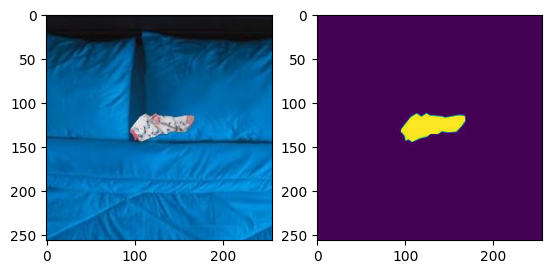

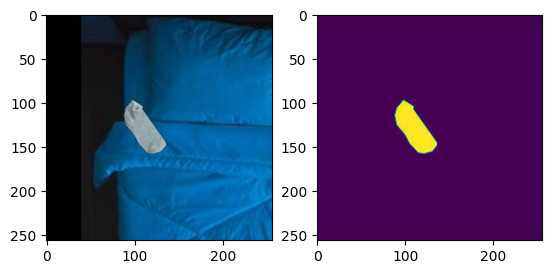

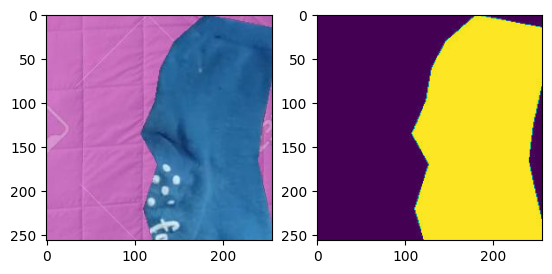

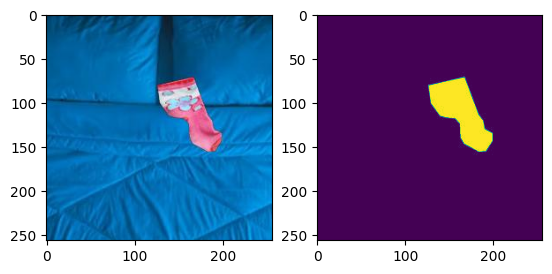

test:  (32, 256, 256, 3) (32, 256, 256, 1)


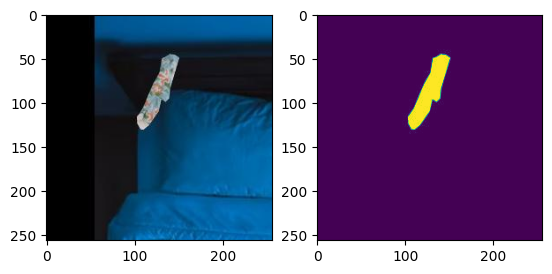

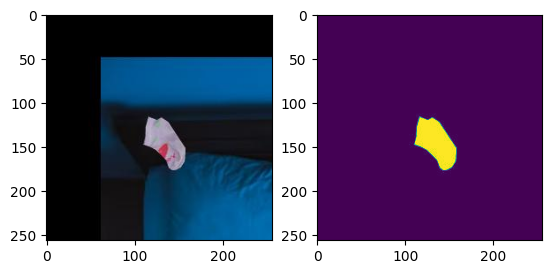

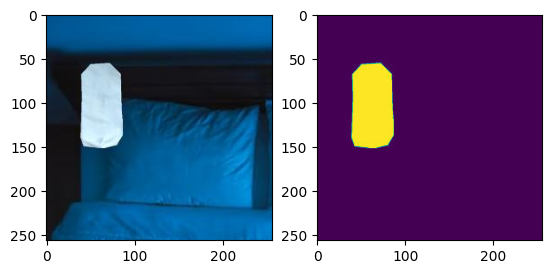

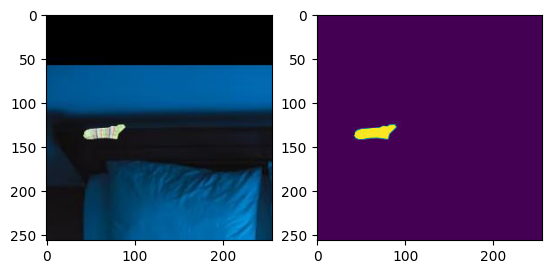

In [22]:
# Split filenames into train and test sets
directory = r"C:\TRABAJO\Apps\socks_matcher\pasted"

# from google.colab import drive
# drive.mount('/content/drive')
# directory = r'/content/drive/MyDrive/Colab Notebooks/pasted'


n_images = 5
image_filenames = os.listdir(os.path.join(directory, "images"))
train_filenames, test_filenames = train_test_split(image_filenames, test_size=0.2, shuffle=True)

# Create Data Generators
train_generator = DataGenerator(os.path.join(directory, "images"),
                                os.path.join(directory, "masks"),
                                batch_size=32,
                                image_size=(256, 256),
                                shuffle=True)
test_generator = DataGenerator(os.path.join(directory, "images"),
                               os.path.join(directory, "masks"),
                               batch_size=32,
                               image_size=(256, 256),
                               shuffle=False)

# Extract images and masks from the generators
images_train, masks_train = next(iter(train_generator))  # Get a batch of data
images_test, masks_test = next(iter(test_generator))    # Get a batch of data


print('train: ', images_train.shape, masks_train.shape)
i = 0
for image, mask in zip(images_train, masks_train):
    i += 1
    if i >= n_images:
        break
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(image)
    ax[1].imshow(mask)
    plt.show()

print('test: ', images_test.shape, masks_test.shape)
i = 0
for image, mask in zip(images_test, masks_test):
    i += 1
    if i >= n_images:
        break
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(image)
    ax[1].imshow(mask)
    plt.show()


# Training

In [23]:
# configure the optimizer, loss and metrics for training
model.compile(optimizer=tf.keras.optimizers.Adam(), loss='binary_crossentropy',
              metrics=['accuracy'])

In [24]:
# # Print dtype of each layer
# for layer in model.layers:
#     print(f'Layer {layer.name} dtype: {layer.dtype}')

# # Print dtype of each weight
# for layer in model.layers:
#     for weight in layer.weights:
#         print(f'Weight {weight.name} dtype: {weight.dtype}')

In [25]:
# # configure the training parameters and train the model
# BATCH_SIZE = 32
# EPOCHS = 10
# VALIDATION_STEPS = 5

# # this will take around 20 minutes to run
# model_history = model.fit(train_generator,
#                           epochs=EPOCHS,
#                           validation_data=test_generator,
#                           validation_steps=VALIDATION_STEPS)

In [26]:
model.load_weights('unet_model_colab_full.h5')


In [27]:
# Evaluate the model i the first batch
loss, accuracy = model.evaluate(images_train, masks_train)
print(f"Training loss: {loss}")
print(f"Training accuracy: {accuracy}")

loss, accuracy = model.evaluate(images_test, masks_test)
print(f"Test loss: {loss}")
print(f"Test accuracy: {accuracy}")

1/1 [==============================] - 35s 35s/step - loss: 0.0078 - accuracy: 0.9768
Training loss: 0.007758972235023975
Training accuracy: 0.9767684936523438
1/1 [==============================] - 46s 46s/step - loss: 0.0036 - accuracy: 0.9862
Test loss: 0.0036004292778670788
Test accuracy: 0.9862370491027832


# Some tests!

train:  (32, 256, 256, 3) (32, 256, 256, 1)
1/1 [==============================] - 3s 3s/step


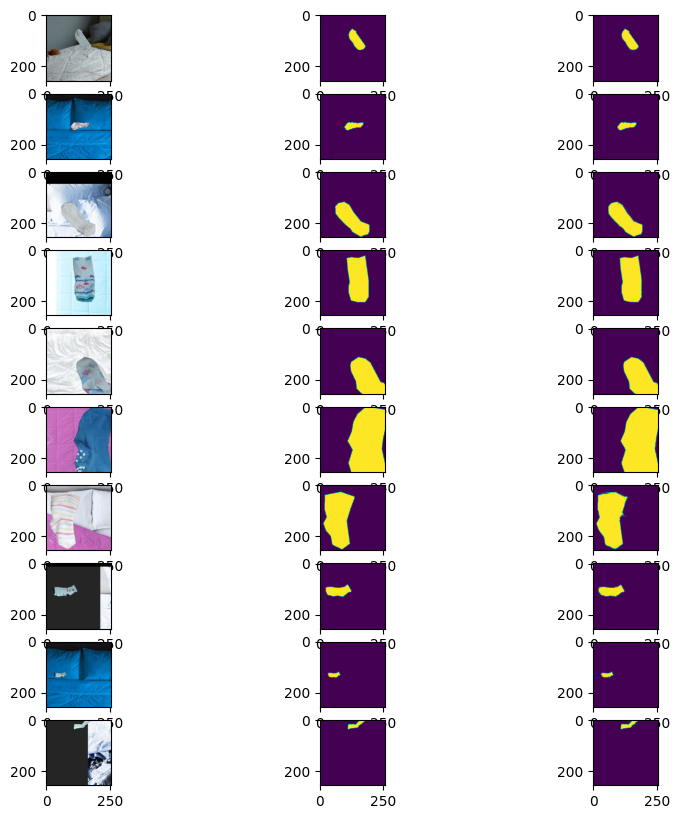


******
test:  (32, 256, 256, 3) (32, 256, 256, 1)
1/1 [==============================] - 2s 2s/step


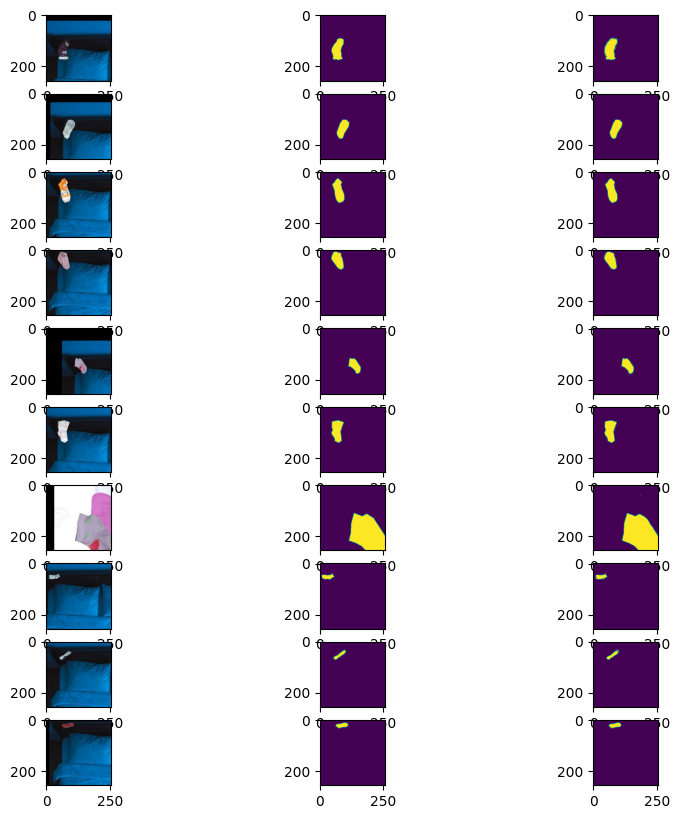

In [28]:
n_images = 10
th = 0.5

print('train: ', images_train.shape, masks_train.shape)
i = 0
fig, ax = plt.subplots(n_images, 3, figsize=(10,10))

# Assuming images_test and masks_test are lists or arrays
indices = list(range(len(images_train)))
random.shuffle(indices)
for i_ax, i in enumerate(indices):
    image = images_train[i, :, :, :]
    mask = masks_train[i, :, :, :]    
    if i_ax >= n_images:
        break
    ax[i_ax,0].imshow(image)
    ax[i_ax,1].imshow(mask)
    ax[i_ax,2].imshow(model.predict(image.reshape((1, )+image.shape))[0])
    i += 1
plt.show()

print('\n******\ntest: ', images_test.shape, masks_test.shape)
i = 0
fig, ax = plt.subplots(n_images, 3, figsize=(10,10))
indices = list(range(len(images_test)))
random.shuffle(indices)
for i_ax, i in enumerate(indices):
    image = images_test[i, :, :, :]
    mask = masks_test[i, :, :, :]  
    if i_ax >= n_images:
        break
    ax[i_ax,0].imshow(image)
    ax[i_ax,1].imshow(mask)
    ax[i_ax,2].imshow(model.predict(image.reshape((1, )+image.shape))[0])
    i += 1
plt.show()

